In [1]:
import pandas as pd
import numpy as np
import os
from feature_extract import ExtractFeature

# read preprocessed data
cwd = os.getcwd()
df = pd.read_csv(cwd + "/data_csv/preprocessing_data.csv")
df.to_csv(cwd + "/data_csv/feature_data.csv", index=False)

In [2]:
df.groupby('emotion').count()

df

,image,emotion
0,facial-expressions_2868585k.jpg,7
1,facial-expressions_2868582k.jpg,3
2,Aaron_Eckhart_0001.jpg,5
3,Aaron_Guiel_0001.jpg,4
4,Aaron_Peirsol_0001.jpg,4
...,...,...
16075,SURPRISE/surprise (967).png,7
16076,SURPRISE/surprise (970).png,7
16077,SURPRISE/surprise (978).jpg,7
16078,SURPRISE/surprise (984).jpg,7


In [3]:
def get_distance(fist_point, second_point):
    distance =  math.sqrt(math.pow(fist_point[0] - second_point[0], 2) + math.pow(fist_point[1] - second_point[1], 2))
    return abs(distance)

def get_angle(first_point, second_point):
    value = (second_point[1] - first_point[1]) / (second_point[0] - first_point[0])
    angle = math.atan(value)
    return angle

len(df)


16080

In [4]:
import cv2, math, numpy as np, dlib
from imutils import face_utils

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(cwd + "/predictor/shape_predictor_68_face_landmarks.dat")

error = []
feature_list = { # [ Feature At 9/4/2022 ]
    "a_top_mouth" : [],
    "a_down_mouth" : [],
    "a_left_mouth" : [],
    "a_right_mouth" : [],
    "a_nose" : [],
    "a_mouth_last_nose": [],
    "a_right_cheek_eye": [],
    "a_left_cheek_eye": [],
    "a_left_eye": [],
    "a_right_eye": [],
    "a_left_eyebrow": [],
    "a_right_eyebrow": [],
    "d_left_eye": [],
    "d_right_eye": [],
    "w_mouth" : [],
    "h_mouth": [],
    "d_top_mouth_chin": [],
    "a_left_mouth_nose": [],
    "a_right_mouth_nose": [],
    "d_top_left_eye_eyebrow": [],
    "d_top_right_eye_eyebrow": [],
    "d_down_mouth_chin" : [],
    "circum_mouth" : []
}
# run each row in train.csv
for idx, row in df.iterrows():
    try:
        imagePath = cwd + "/cleaned_images/" + row.image
        image = cv2.imread(imagePath)

        # detect face with haarcascade
        face_cascade = cv2.CascadeClassifier('haarcascade/haarcascade_frontalface_alt.xml')
        eye_cascade = cv2.CascadeClassifier('haarcascade/haarcascade_eye_tree_eyeglasses.xml')
        smile_cascade = cv2.CascadeClassifier('haarcascade/haarcascade_smile.xml')

        face = face_cascade.detectMultiScale(
            image,
            scaleFactor = 1.1,
            minNeighbors = 4,
            minSize = (200, 200),
            flags = cv2.CASCADE_SCALE_IMAGE
        )
        
        if len(face) != 1:
            error.append(idx)
            continue

        for (x, y, w, h) in face:
            roi_gray = image[y:y+h, x:x+w]

        smile = smile_cascade.detectMultiScale(
            roi_gray,
            scaleFactor = 1.16,
            minNeighbors = 35,
            minSize = (25, 25),
            flags = cv2.CASCADE_SCALE_IMAGE
        )
        
        if len(smile) < 1:
            error.append(idx)
            continue

        eyes = eye_cascade.detectMultiScale(roi_gray)

        if len(eyes) < 2:
            error.append(idx)
            continue
        
        # detect face with shape predictor
        rects = detector(image, 0)

        if len(rects) == 0:
            error.append(idx)
            continue

        rects = detector(image, 0)

        xlist = []
        ylist = []
        # loop over the face detections
        for (i, rect) in enumerate(rects):
            # determine the facial landmarks and convert the facial landmark (x, y)
            shape = predictor(image, rect)
            shape = face_utils.shape_to_np(shape)

            # loop over coordinates, draw them on the image and store coordinates in two lists
            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
                xlist.append(x)
                ylist.append(y)

        # get mean of both axes to determine centre of gravity
        if(len(xlist) == 0 or len(ylist) == 0):
            error.append(idx)
            continue

        extract = ExtractFeature(xlist, ylist)

        feature_list["a_top_mouth"].append(extract.get_angle(49, 52, 55))
        feature_list["a_down_mouth"].append(extract.get_angle(49, 58, 55))
        feature_list["a_left_mouth"].append(extract.get_angle(50, 49, 60))
        feature_list["a_right_mouth"].append(extract.get_angle(52, 55, 58))
        feature_list["a_nose"].append(extract.get_angle(32, 34, 36))
        feature_list["a_mouth_last_nose"].append(extract.get_angle(49, 34, 55))
        feature_list["a_right_cheek_eye"].append(extract.get_angle(55, 16, 36))
        feature_list["a_left_cheek_eye"].append(extract.get_angle(49, 2, 32))
        feature_list["a_left_eye"].append(extract.get_angle(38, 37, 42))
        feature_list["a_right_eye"].append(extract.get_angle(45, 46, 47))
        feature_list["a_left_eyebrow"].append(extract.get_angle(18, 20, 22))
        feature_list["a_right_eyebrow"].append(extract.get_angle(23, 25, 27))
        feature_list["d_left_eye"].append(extract.get_distance(37, 40))
        feature_list["d_right_eye"].append(extract.get_distance(43, 46))
        feature_list["w_mouth"].append(extract.get_distance(49, 55))
        feature_list["h_mouth"].append(extract.get_distance(52, 58))
        feature_list["d_top_mouth_chin"].append(extract.get_distance(52, 9))
        feature_list["a_left_mouth_nose"].append(extract.get_angle(3, 49, 34))
        feature_list["a_right_mouth_nose"].append(extract.get_angle(34, 55, 15))
        feature_list["d_top_left_eye_eyebrow"].append(extract.get_distance(40, 22))
        feature_list["d_top_right_eye_eyebrow"].append(extract.get_distance(43, 23))
        feature_list["d_down_mouth_chin"].append(extract.get_distance(58, 9))
        feature_list["circum_mouth"].append(
            sum(
                [extract.get_distance(x, x + 1) for x in range(61, 68)] + 
                [extract.get_distance(61, 68)]
            )
        )
    # cv2.circle(image, (int(xmean), int(ymean)), 1, (0, 255, 0), -1)

    except:
        error.append(idx)
        continue

d:\TU\2564_2\CN240\FacialCleanData\feature_extract.py:18: RuntimeWarning: divide by zero encountered in long_scalars
  alpha = math.atan( (y[p1] - y[p2]) / (x[p1] - x[p2]) )


In [5]:
# df = new_df.copy()
print(len(error))
new_df = df.copy()
new_df['emotion']

1


0        7
1        3
2        5
3        4
4        4
        ..
16075    7
16076    7
16077    7
16078    7
16079    7
Name: emotion, Length: 16080, dtype: int64

In [6]:
df.drop(error, axis=0, inplace=True)
print(len(df))

16079


In [7]:
# add feature to df
df["a_top_mouth"] = feature_list["a_top_mouth"]  
df["a_down_mouth"] = feature_list["a_down_mouth"] 
df["a_left_mouth"] = feature_list["a_left_mouth"] 
df["a_right_mouth"] = feature_list["a_right_mouth"] 
df["a_nose"] = feature_list["a_nose"] 
df["a_mouth_last_nose"] = feature_list["a_mouth_last_nose"] 
df["a_right_cheek_eye"] = feature_list["a_right_cheek_eye"] 
df["a_left_cheek_eye"] = feature_list["a_left_cheek_eye"] 
df["a_left_eye"] = feature_list["a_left_eye"] 
df["a_right_eye"] = feature_list["a_right_eye"] 
df["a_left_eyebrow"] = feature_list["a_left_eyebrow"] 
df["a_right_eyebrow"] = feature_list["a_right_eyebrow"] 
df["d_left_eye"] = feature_list["d_left_eye"] 
df["d_right_eye"] = feature_list["d_right_eye"] 
df["w_mouth"] = feature_list["w_mouth"] 
df["h_mouth"] = feature_list["h_mouth"] 
df["d_top_mouth_chin"] = feature_list["d_top_mouth_chin"] 
df["a_left_mouth_nose"] = feature_list["a_left_mouth_nose"] 
df["a_right_mouth_nose"] = feature_list["a_right_mouth_nose"] 
df["d_top_left_eye_eyebrow"] = feature_list["d_top_left_eye_eyebrow"] 
df["d_top_right_eye_eyebrow"] = feature_list["d_top_right_eye_eyebrow"] 
df["d_down_mouth_chin"] = feature_list["d_down_mouth_chin"]  
df["circum_mouth"] = feature_list["circum_mouth"]  
# 20 Features


In [8]:
df
new_df = df.copy()
df['emotion']

0        7
1        3
2        5
3        4
4        4
        ..
16075    7
16076    7
16077    7
16078    7
16079    7
Name: emotion, Length: 16079, dtype: int64

In [9]:
df.groupby('emotion').count()

,image,a_top_mouth,a_down_mouth,a_left_mouth,a_right_mouth,a_nose,a_mouth_last_nose,a_right_cheek_eye,a_left_cheek_eye,a_left_eye,...,d_right_eye,w_mouth,h_mouth,d_top_mouth_chin,a_left_mouth_nose,a_right_mouth_nose,d_top_left_eye_eyebrow,d_top_right_eye_eyebrow,d_down_mouth_chin,circum_mouth
emotion,,,,,,,,,,,,,,,,,,,,,
0,987,987,987,987,987,987,987,987,987,987,...,987,987,987,987,987,987,987,987,987,987
1,1343,1343,1343,1343,1343,1343,1343,1343,1343,1343,...,1343,1343,1343,1343,1343,1343,1343,1343,1343,1343
2,920,920,920,920,920,920,920,920,920,920,...,920,920,920,920,920,920,920,920,920,920
3,1192,1192,1192,1192,1192,1192,1192,1192,1192,1192,...,1192,1192,1192,1192,1192,1192,1192,1192,1192,1192
4,4541,4541,4541,4541,4541,4541,4541,4541,4541,4541,...,4541,4541,4541,4541,4541,4541,4541,4541,4541,4541
5,4615,4615,4615,4615,4615,4615,4615,4615,4615,4615,...,4615,4615,4615,4615,4615,4615,4615,4615,4615,4615
6,1151,1151,1151,1151,1151,1151,1151,1151,1151,1151,...,1151,1151,1151,1151,1151,1151,1151,1151,1151,1151
7,1330,1330,1330,1330,1330,1330,1330,1330,1330,1330,...,1330,1330,1330,1330,1330,1330,1330,1330,1330,1330


23


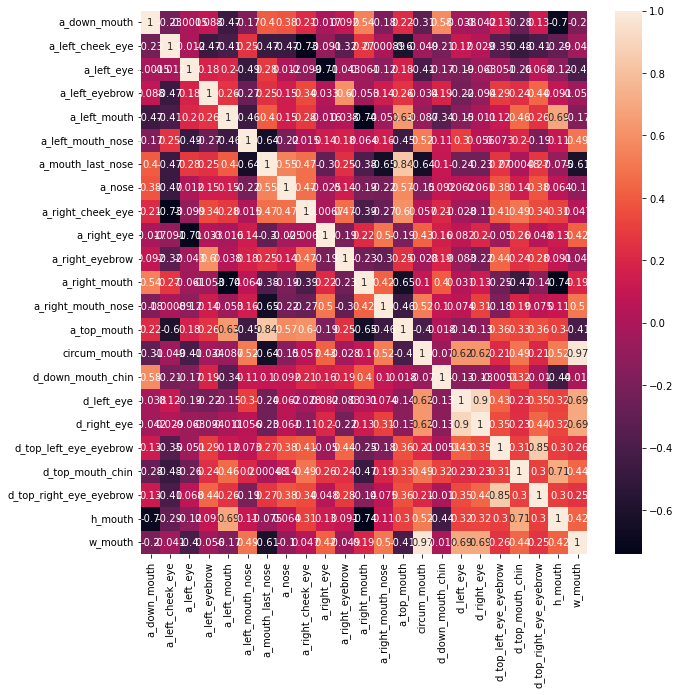

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt
X = df[df.columns.difference(['Unnamed: 0', 'emotion', 'image'])]
corr = X.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corr, annot=True)
print(len(X.columns))


In [11]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.9:
            if columns[j]:
                columns[j] = False

print("Filter Method : ", len(corr.columns[columns]))
selected_columns = list(corr.columns[columns]) + ['emotion', 'image']
print(selected_columns)
# data = corr[selected_columns]
# print(selected_columns)
# selected_columns.append('emotion')

Filter Method :  22
['a_down_mouth', 'a_left_cheek_eye', 'a_left_eye', 'a_left_eyebrow', 'a_left_mouth', 'a_left_mouth_nose', 'a_mouth_last_nose', 'a_nose', 'a_right_cheek_eye', 'a_right_eye', 'a_right_eyebrow', 'a_right_mouth', 'a_right_mouth_nose', 'a_top_mouth', 'circum_mouth', 'd_down_mouth_chin', 'd_left_eye', 'd_right_eye', 'd_top_left_eye_eyebrow', 'd_top_mouth_chin', 'd_top_right_eye_eyebrow', 'h_mouth', 'emotion', 'image']


In [12]:
df_filter = new_df.copy()
print(new_df)
df_filter = df_filter[selected_columns]
print(df_filter)

                                 image  emotion  a_top_mouth  a_down_mouth  \
0      facial-expressions_2868585k.jpg        7     0.842547     -1.414526   
1      facial-expressions_2868582k.jpg        3     0.281292     -0.764688   
2               Aaron_Eckhart_0001.jpg        5     0.029403     -0.681835   
3                 Aaron_Guiel_0001.jpg        4     0.423111     -0.952620   
4               Aaron_Peirsol_0001.jpg        4    -0.069655     -1.173123   
...                                ...      ...          ...           ...   
16075      SURPRISE/surprise (967).png        7     0.131859     -1.107149   
16076      SURPRISE/surprise (970).png        7     0.207676     -1.499489   
16077      SURPRISE/surprise (978).jpg        7     1.024245     -1.446441   
16078      SURPRISE/surprise (984).jpg        7     1.010084     -1.115170   
16079      SURPRISE/surprise (993).jpg        7     1.618112     -1.228091   

       a_left_mouth  a_right_mouth    a_nose  a_mouth_last_nose

C:\Users\omsin\AppData\Local\Temp/ipykernel_24972/3834602630.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


<AxesSubplot:>

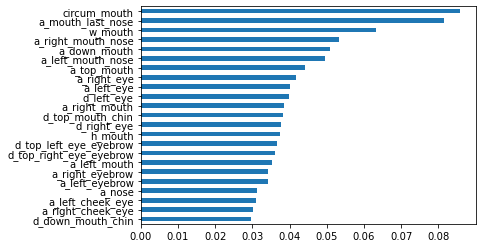

In [13]:
# Critical To Model (Feature important)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=250, random_state=7)

X = df[df.columns.difference(['emotion', 'image'])]
y = df[['emotion']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model.fit(X_train, y_train)  

fs = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
fs.plot(kind='barh')

In [14]:
important = list(model.feature_importances_)
print(important)

[0.05094506792091568, 0.030856199710437786, 0.040114353608905126, 0.034267819738827345, 0.03512718044756874, 0.04958138114827266, 0.08138757135023253, 0.03115329277285499, 0.030169475028823542, 0.04166646015241222, 0.03430716660187567, 0.038430739670371625, 0.053349082481541306, 0.04416581500536494, 0.08570318483571665, 0.029555396755113737, 0.03973268516705416, 0.03771476714919892, 0.036644940749104626, 0.038342432104737104, 0.03610913877629434, 0.037414054367828624, 0.06326179445654781]


In [15]:
# Wrapper (Backward Elimination)
import statsmodels.api as sm
from sklearn.feature_selection import RFE

X_1 = sm.add_constant(X)
model = sm.OLS(y,X_1).fit()
model.pvalues

const                      1.581763e-05
a_down_mouth               9.549517e-11
a_left_cheek_eye           1.343638e-02
a_left_eye                 3.384683e-01
a_left_eyebrow             9.135421e-06
a_left_mouth               9.776127e-11
a_left_mouth_nose          6.783020e-01
a_mouth_last_nose          2.283009e-04
a_nose                     2.879358e-01
a_right_cheek_eye          1.799232e-01
a_right_eye                6.369120e-02
a_right_eyebrow            5.593975e-03
a_right_mouth              8.988148e-05
a_right_mouth_nose         3.452748e-03
a_top_mouth                1.791874e-08
circum_mouth               8.673554e-07
d_down_mouth_chin          1.488711e-03
d_left_eye                 3.417828e-01
d_right_eye                6.187379e-01
d_top_left_eye_eyebrow     2.252665e-09
d_top_mouth_chin           2.076498e-03
d_top_right_eye_eyebrow    2.291745e-12
h_mouth                    8.864776e-04
w_mouth                    8.952434e-02
dtype: float64

In [16]:
cols = list(X.columns)
pmax = 1

while len(cols) > 0:
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)

    model = sm.OLS(y,X_1).fit()

    p = pd.Series(model.pvalues.values[1:], index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if pmax > 0.05 :
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = list(cols)
print("Number of Feature Selected BE : ", len(selected_features_BE))
print(selected_features_BE)

Number of Feature Selected BE :  16
['a_down_mouth', 'a_left_cheek_eye', 'a_left_eyebrow', 'a_left_mouth', 'a_mouth_last_nose', 'a_right_eye', 'a_right_eyebrow', 'a_right_mouth', 'a_right_mouth_nose', 'a_top_mouth', 'circum_mouth', 'd_down_mouth_chin', 'd_top_left_eye_eyebrow', 'd_top_mouth_chin', 'd_top_right_eye_eyebrow', 'h_mouth']


In [17]:
from sklearn.linear_model import LinearRegression

#no of features
nof_list = np.arange(1,21)            
high_score = 0

#Variable to store the optimum features
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 0)

    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=nof_list[n])

    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)

    model.fit(X_train_rfe,y_train)

    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if score > high_score:
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 20
Score with 20 features: 0.141911


In [18]:
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, n_features_to_select=14)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y) 
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)
cols = list(X.columns)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = list(temp[temp==True].index)
print("Number of feature rfe : ", len(selected_features_rfe))

# end of Wrapper (Backward Elimination)

[ True  True  True  True  True False  True False  True  True  True  True
 False  True False  True False False False  True False  True False]
[ 1  1  1  1  1  6  1  4  1  1  1  1  2  1  7  1  9 10  5  1  3  1  8]
Number of feature rfe :  14


In [19]:
# selected_features_rfe = selected_features_rfe.extend(['emotion', 'image'])
selected_features_rfe = ['image', 'emotion'] + selected_features_rfe
df_wrapper = new_df.copy()
df_wrapper = df_wrapper[selected_features_rfe]
df_wrapper.to_csv(cwd + "/data_csv/use_feature_data_wrapper.csv", index=False)


In [20]:
# Embedded
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

D:\DownloadApplication\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\DownloadApplication\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.718188925508002, tolerance: 5.111228904610117
  model = cd_fast.enet_coordinate_descent_gram(
D:\DownloadApplication\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.26772423123839, tolerance: 3.976768856409856
  model = cd_fast.enet_coordinate_descent_gram(
D:\DownloadApplication\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

Best alpha using built-in LassoCV: 0.660761
Best score using built-in LassoCV: 0.111921


D:\DownloadApplication\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.26126040411327, tolerance: 5.222673233304829
  model = cd_fast.enet_coordinate_descent_gram(


In [21]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 4 variables and eliminated the other 19 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

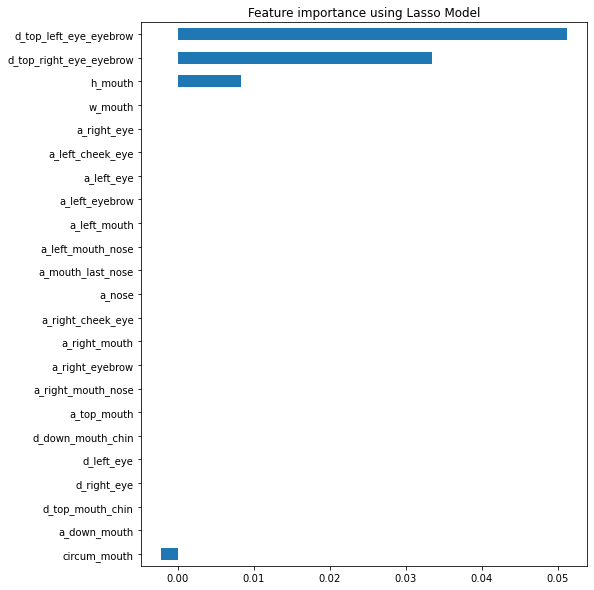

In [22]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [27]:
feature_selected_embed = [
    'image',
    'emotion',
    'd_top_left_eye_eyebrow',
    'd_top_right_eye_eyebrow', 
    'h_mouth',
    'circum_mouth',
]
df_embedded = new_df.copy()
df_embedded = df_embedded[feature_selected_embed]
print(len(df_embedded.columns))
df_embedded.to_csv(cwd + "/data_csv/use_feature_data_embedded.csv", index=False)


6


In [28]:
# Wrapper Methods
from sklearn.ensemble import GradientBoostingClassifier
estimator = GradientBoostingClassifier(n_estimators = 100)
selector = RFE(estimator, step= 1)
selector = selector.fit(X_train, y_train)

D:\DownloadApplication\anaconda\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\DownloadApplication\anaconda\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\DownloadApplication\anaconda\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\DownloadApplication\anaconda\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

In [29]:
sel_cols = np.array(X.columns)[selector.support_]
sel_cols

array(['a_down_mouth', 'a_left_eye', 'a_left_mouth_nose',
       'a_mouth_last_nose', 'a_right_mouth', 'a_right_mouth_nose',
       'a_top_mouth', 'circum_mouth', 'd_left_eye',
       'd_top_left_eye_eyebrow', 'w_mouth'], dtype=object)

In [30]:
df_embedded_2 = new_df.copy()
df_embedded_2 = df_embedded_2[['image', 'emotion'] + list(sel_cols)]
df_embedded_2.to_csv(cwd + "/data_csv/use_feature_data_embedded_2.csv", index=False)